# Market Making with Signals through Deep Reinforcement Learning #

[Paper: Market Making with signals through DRL (GAŠPEROV et. al., 2021)](docs/ref/Market_Making_With_Signals_Through_Deep_Reinforcement_Learning.pdf)

Author: Kas Wei

Email: jwei2002@uw.edu

## Introduction ##

`Training Framework`

- Phase I: Signal Generation

    - SGU1 (Volatility): Utilizes XGBoost for volatility forecasting.

    - SGU2 (Returns): Employs an LSTM network to predict mid-price returns.

- Phase II: Strategy Optimization

    - Input: Integrates predicted volatility, returns, and normalized inventory into a composite feature vector.

    - Agent Training: Applies a Genetic Algorithm (GA) to optimize the agent’s market-making logic.

    - Output: Generates optimal bid/ask offset values.

`Data Partitioning`

- Initial Split (75/10/15): The dataset is partitioned into training, validation, and testing sets.

- SGU Calibration: The initial 85% of the data is dedicated exclusively to SGU training and validation. Model weights and scalers are computed on the training set and subsequently frozen to prevent data leakage.

- Agent Optimization: Within the remaining test partition, the same 75/10/15 ratio is applied for the agent’s training, validation, and final OOS (Out-of-Sample) testing.

- Time Bar: Trades aggregation base on snapshot (3s) and backtest on tick level data.

- Event Bar: Every 19 shifts in the top level of limit order book (LOB) will be defined as a single event. This is the essential step for agent's decisions.

`Underlying Asset`

In this project I pick `CSI300 ETF (510300.SH)` for its great liquidity.

## Part 1: Signal Gated Units

In this part, we use the snapshot and trades data from 20240401 to 20240528 to train & validate the two SGUs: XGB for volatility prediction and LSTM for mid-price returns.

- train_range=(20240401, 20240528)

- val_range=(20240529, 20240612)

In [1]:
import warnings
warnings.filterwarnings('ignore')
from pipeline.sgu_trainer import run_sgu_training

In [2]:
run_sgu_training(symbol='510300', train_range=(20240401, 20240528), val_range=(20240529, 20240612), event_step=19, time_steps=10)


>>> Loading Data for 510300...


[SGU1] Validation -> Corr: 0.4749
Early stopping at epoch 42
[SGU2] Validation -> Corr: 0.2667
>>> SGU training complete. Weights frozen in checkpoints/510300


## Part 2: Market Making Agent

`Generic Algorithm`:

- Generations: 100
- Population: 50
- Decay Principle: For each 15-generations, shrink the rate of mutate to the half if no improvement on agent's score

`Reward Function`:

$$R_{t+1}=PnL_{t}-\lambda \cdot I_{t+1}$$

Where $\lambda $ is the tolerance of inventory per tick, here we set $\lambda=0.0001$ for `CSI300 ETF` with tick size `0.001`

In [3]:
from pipeline.agent_trainer import run_agent_training_pipeline

DRL agent without adversarial mm-agent

SGU2 model loaded from checkpoints/510300\sgu2_20240401_20240528.pth and set to eval mode.
>>> Agent Dates after: 20240528:
    S3 Total: 22 days | Train: 15 | Val: 3 | Test: 4


Gen 000 | ARL:OFF | Best Train: 2.03 | Val: 0.51*
Gen 005 | ARL:OFF | Best Train: 2.13 | Val: 0.49
Gen 010 | ARL:OFF | Best Train: 2.15 | Val: 0.50
Gen 015 | ARL:OFF | Best Train: 1.99 | Val: 0.40
Gen 020 | ARL:OFF | Best Train: 1.59 | Val: 0.38
>>> Sigma decayed to 0.0250 due to no improvement
Gen 025 | ARL:OFF | Best Train: 1.91 | Val: 0.41
Gen 030 | ARL:OFF | Best Train: 2.09 | Val: 0.48
Gen 035 | ARL:OFF | Best Train: 2.22 | Val: 0.47
Gen 040 | ARL:OFF | Best Train: 2.34 | Val: 0.52
Gen 045 | ARL:OFF | Best Train: 2.08 | Val: 0.42
>>> Sigma decayed to 0.0125 due to no improvement
Gen 050 | ARL:OFF | Best Train: 2.04 | Val: 0.38
Gen 055 | ARL:OFF | Best Train: 2.22 | Val: 0.46
Gen 060 | ARL:OFF | Best Train: 2.30 | Val: 0.51
>>> Sigma decayed to 0.0063 due to no improvement
Gen 065 | ARL:OFF | Best Train: 2.39 | Val: 0.51
Gen 070 | ARL:OFF | Best Train: 2.41 | Val: 0.52
Gen 075 | ARL:OFF | Best Train: 2.42 | Val: 0.55*
Gen 080 | ARL:OFF | Best Train: 2.45 | Val: 0.53
Gen 085 | ARL:O

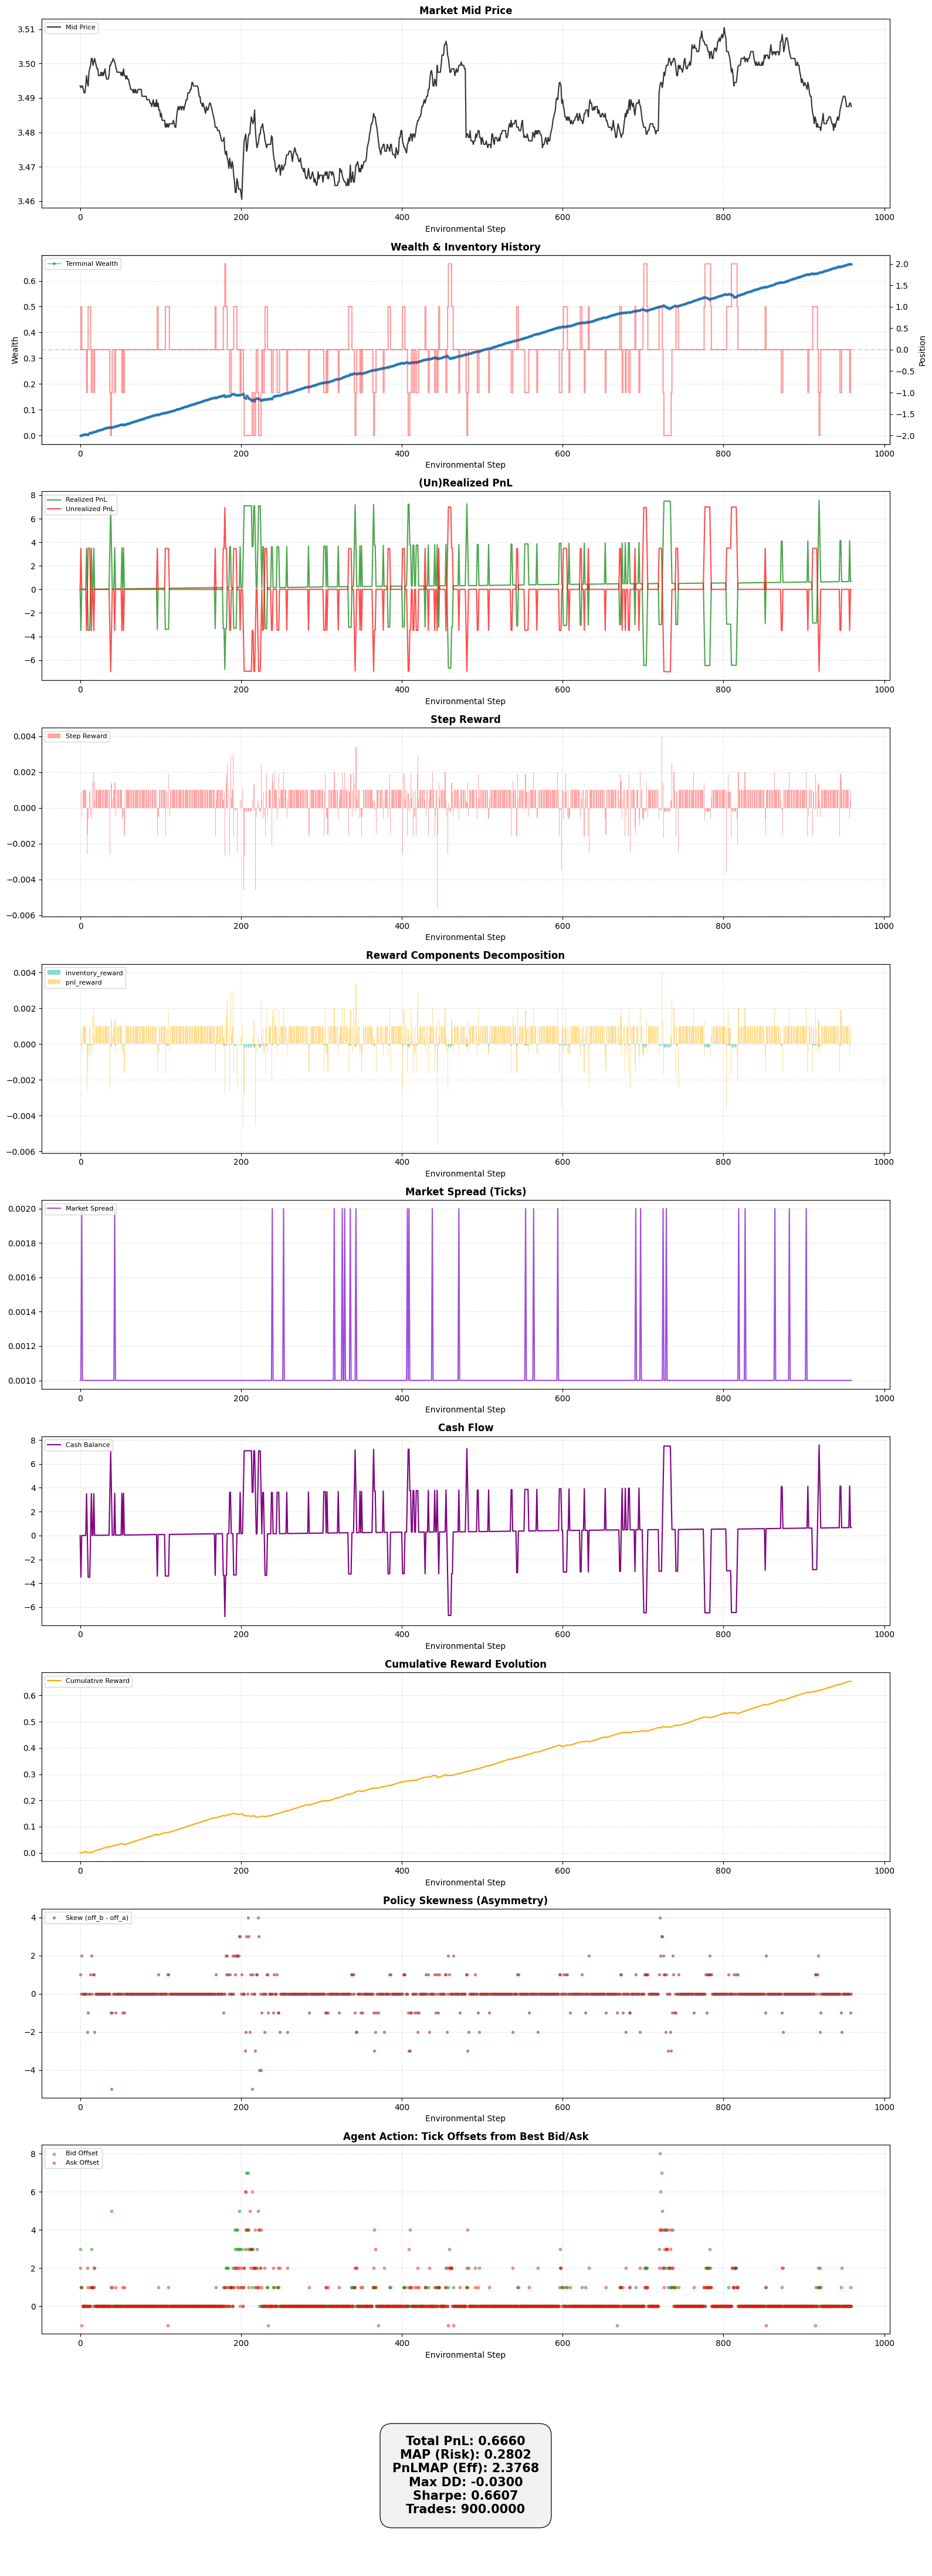

In [4]:
run_agent_training_pipeline(symbol='510300', sgu_train_range=(20240401, 20240528), PHI=0.0001, TICK_SIZE=0.001, fee_rate=0.0000, USE_FEE=False, USE_ARL=False, nb_mode=True)

DRL agent with adversarial mm-agent

SGU2 model loaded from checkpoints/510300\sgu2_20240401_20240528.pth and set to eval mode.
>>> Agent Dates after: 20240528:
    S3 Total: 22 days | Train: 15 | Val: 3 | Test: 4


Gen 000 | ARL:ON | Best Train: 2.20 | Val: 0.52*
Gen 005 | ARL:ON | Best Train: 2.05 | Val: 0.49
Gen 010 | ARL:ON | Best Train: 2.14 | Val: 0.47
Gen 015 | ARL:ON | Best Train: 1.36 | Val: 0.35
Gen 020 | ARL:ON | Best Train: 1.52 | Val: 0.37
>>> Sigma decayed to 0.0250 due to no improvement
Gen 025 | ARL:ON | Best Train: 1.56 | Val: 0.23
Gen 030 | ARL:ON | Best Train: 1.34 | Val: 0.26
Gen 035 | ARL:ON | Best Train: 1.43 | Val: 0.24
>>> Sigma decayed to 0.0125 due to no improvement
Gen 040 | ARL:ON | Best Train: 1.71 | Val: 0.28
Gen 045 | ARL:ON | Best Train: 1.90 | Val: 0.37
Gen 050 | ARL:ON | Best Train: 2.10 | Val: 0.36
>>> Sigma decayed to 0.0063 due to no improvement
Gen 055 | ARL:ON | Best Train: 2.17 | Val: 0.35
Gen 060 | ARL:ON | Best Train: 2.16 | Val: 0.37
Gen 065 | ARL:ON | Best Train: 2.22 | Val: 0.41
>>> Sigma decayed to 0.0031 due to no improvement
Gen 070 | ARL:ON | Best Train: 2.14 | Val: 0.40
Gen 075 | ARL:ON | Best Train: 2.16 | Val: 0.36
Gen 080 | ARL:ON | Best Train: 

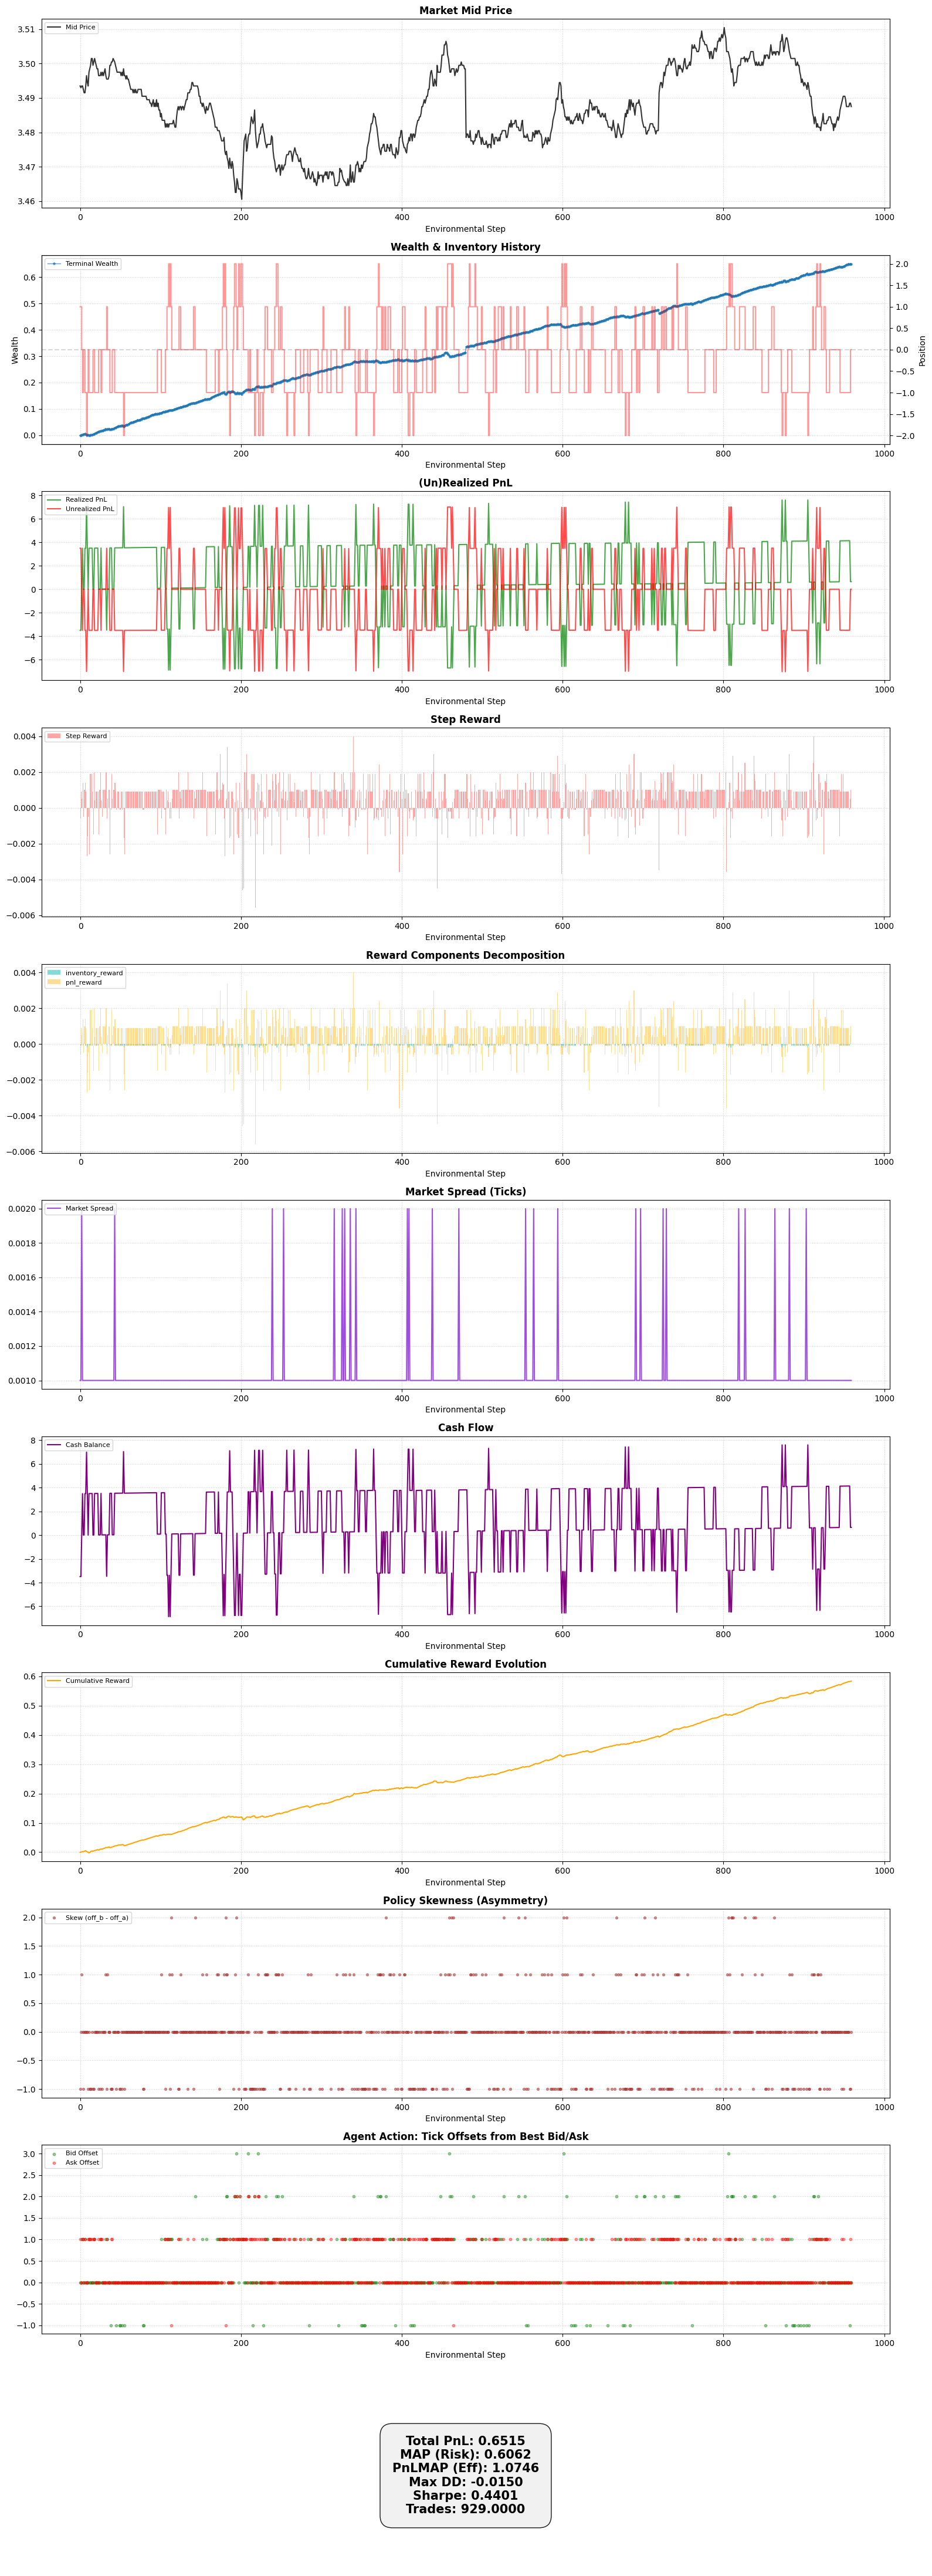

In [5]:
run_agent_training_pipeline(symbol='510300', sgu_train_range=(20240401, 20240528), PHI=0.0001, TICK_SIZE=0.001, fee_rate=0.0000, USE_FEE=False, USE_ARL=True, nb_mode=True)

ARL does not achieve a Sharpe and PnL as high as DRL, while it significantly reduces its orders' offsets to BBO 

## Part 3: Comparison

In this section, we run backtest for four components on the same OOS data:

- `DRL MM Agent with adversarial training (DRL1)`
- `DRL MM Agent (DRL2)`
- `GLFT`
- `FOIC`

In [6]:
import os
import torch
import numpy as np
import pickle
import shutil
from Env.market_env import FTPEnv
from Env.recorder import StrategyRecorder
from models.model import TradingPolicy
from Env.benchmarks import FOICPolicy, GLFTPolicy
from models.GateUnits import SGU1, SGU2
from pipeline.agent_trainer import load_signals_bundle

In [7]:
def run_drl_backtest(symbol, method_name, weight_path, bundle, phi, fee_rate, train_stats):
    s1, s2, mid, ask, bid, b_max, s_min = bundle 

    policy = TradingPolicy()
    if os.path.exists(weight_path):
        policy.load_state_dict(torch.load(weight_path, weights_only=True))
        policy.eval()
    else:
        print(f"Warning: Weights not found at {weight_path}")
        return None
    
    env = FTPEnv(phi=phi, tick_size=0.001, fee_rate=fee_rate) 
    recorder = StrategyRecorder()

    with torch.no_grad():
        for t in range(len(mid)):
            n_s = torch.tensor([[(s1[t]-train_stats['s1_m'])/train_stats['s1_s'], 
                                 (s2[t]-train_stats['s2_m'])/train_stats['s2_s'], 
                                 env.inventory/2.0]], dtype=torch.float32)
            
            raw_act = policy.forward(n_s).squeeze().cpu().numpy()
            scaled_act = np.round(raw_act * 5.0).astype(int) 

            reward, info = env.step(scaled_act, mid[t], ask[t], bid[t], b_max[t], s_min[t])

            record_data = {
                'step': t,
                'mid': mid[t],
                'ask': ask[t],
                'bid': bid[t],
                'off_a': scaled_act[0], 
                'off_b': scaled_act[1], 
                'action': scaled_act,
                'reward': reward,
                'inventory': env.inventory,
                'cash': env.cash,
                'fee_paid': info.get('fee_paid', 0.0), 
                's1_pred': s1[t],
                's2_pred': s2[t]
            }
            record_data.update(info)
            recorder.data.append(record_data)
            
    df = recorder.to_dataframe() 
    save_path = f"output/{symbol}/{method_name}/backtest_{phi}.parquet"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_parquet(save_path, index=False)
    print(f"Success: {method_name} backtest completed.")
    return df

def run_benchmark_and_save(strategy_name, policy, bundle, phi_param, fee_rate, save_dir, train_stats):
    s1, s2, mid, ask, bid, b_max, s_min = bundle
    env = FTPEnv(phi=phi_param, tick_size=0.001, fee_rate=fee_rate)
    recorder = StrategyRecorder()

    for t in range(len(mid)):
        raw_offsets = policy.get_action(env.inventory)
        mid_p = (ask[t] + bid[t]) / 2.0

        if strategy_name == 'glft':
            off_a = ((mid_p + raw_offsets[0]) - ask[t]) / 0.001
            off_b = (bid[t] - (mid_p - raw_offsets[1])) / 0.001
            action = np.round([off_a, off_b]).astype(int)
        else:
            action = np.round(raw_offsets).astype(int)
        
        reward, info = env.step(action, mid[t], ask[t], bid[t], b_max[t], s_min[t])

        record_data = {
            'step': t, 'mid': mid[t], 'ask': ask[t], 'bid': bid[t],
            'off_a': action[0], 'off_b': action[1], 
            'action': action, 'reward': reward, 'inventory': env.inventory, 'cash': env.cash,
            'fee_paid': info.get('fee_paid', 0.0),
            's1_pred': s1[t], 's2_pred': s2[t]
        }
        record_data.update(info)
        recorder.data.append(record_data)
        
    df = recorder.to_dataframe()
    save_path = f"{save_dir}/backtest_{phi_param}.parquet"
    os.makedirs(save_dir, exist_ok=True)
    df.to_parquet(save_path, index=False)
    print(f"Success: {strategy_name} benchmark completed.")
    return df

In [8]:
symbol = "510300"
phi_val = 0.0001
fee_rate = 0.0000
sgu_train_range = (20240401, 20240528)
base_path = os.path.abspath("checkpoints") 
checkpoint_dir = os.path.join(base_path, symbol)

In [9]:
# loading signals and scaler
m1 = SGU1()
s1_raw_path = os.path.join(checkpoint_dir, f"sgu1_{sgu_train_range[0]}_{sgu_train_range[1]}.json")
tmp_s1_path = "tmp_sgu1_model.json"
shutil.copy2(s1_raw_path, tmp_s1_path)
try:
    m1.load(tmp_s1_path)
    print(">>> SGU1 loaded successfully.")
finally:
    if os.path.exists(tmp_s1_path):
        os.remove(tmp_s1_path)

m2 = SGU2(input_size=1, hidden_size=10)
s2_path = os.path.join(checkpoint_dir, f"sgu2_{sgu_train_range[0]}_{sgu_train_range[1]}.pth")
m2.load(s2_path)
print(">>> SGU2 (LSTM) loaded successfully.")

scaler_path = os.path.join(checkpoint_dir, f"sgu2_scaler_{sgu_train_range[0]}_{sgu_train_range[1]}.pkl")
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
    
s3_start_date = sgu_train_range[1]
print(f">>> Scaler loaded. S3 evaluation starts after: {s3_start_date}")

>>> SGU1 loaded successfully.
SGU2 model loaded from d:\UW\Course\2026 WINTER\522_trade_sys\replication\checkpoints\510300\sgu2_20240401_20240528.pth and set to eval mode.
>>> SGU2 (LSTM) loaded successfully.
>>> Scaler loaded. S3 evaluation starts after: 20240528


In [10]:
snap_dir = f'data/{symbol}/snap'
all_dates = sorted([f[:8] for f in os.listdir(snap_dir) if f.endswith('.parquet')])
s3_dates = [d for d in all_dates if int(d) > s3_start_date]
n_s3 = len(s3_dates)
if n_s3 < 5:
    raise ValueError(f"Insufficient S3 data after {s3_start_date}.")

train_idx = int(n_s3 * 0.70)
val_idx = int(n_s3 * 0.85)

train_dates = s3_dates[:train_idx]
test_dates = s3_dates[val_idx:]

print(f">>> S3 Data Pool: {n_s3} days | Train-subset: {len(train_dates)} | Test-subset: {len(test_dates)}")

print("Bundling S3-Train data...")
train_bundle = load_signals_bundle(symbol, train_dates, m1, m2, scaler)
print("Bundling S3-Test data...")
s3_bundle = load_signals_bundle(symbol, test_dates, m1, m2, scaler)

>>> S3 Data Pool: 22 days | Train-subset: 15 | Test-subset: 4
Bundling S3-Train data...


Bundling S3-Test data...


In [11]:
s1_t, s2_t = train_bundle[0], train_bundle[1]

train_stats = {
    's1_m': np.mean(s1_t), 
    's1_s': np.std(s1_t) + 1e-9,
    's2_m': np.mean(s2_t), 
    's2_s': np.std(s2_t) + 1e-9
}

print(f">>> Normalization stats locked: {train_stats}")

>>> Normalization stats locked: {'s1_m': 2.0911791, 's1_s': 0.3246540139184723, 's2_m': 0.027029233, 's2_s': 0.5160724530683288}


In [12]:
path_drl = os.path.join(checkpoint_dir, f"without_adv/agent_best_val_{phi_val}.pth")
path_arl = os.path.join(checkpoint_dir, f"with_adv/agent_best_val_{phi_val}.pth")
# DRL
run_drl_backtest(symbol, "drl", path_drl, s3_bundle, phi_val, fee_rate, train_stats)
# Adv DRL
run_drl_backtest(symbol, "arl", path_arl, s3_bundle, phi_val, fee_rate, train_stats)
# GLFT
glft_p = GLFTPolicy(gamma=0.0001, kappa=3000, A=0.1, sigma=0.0005)
run_benchmark_and_save("glft", glft_p, s3_bundle, phi_val, fee_rate, f"output/{symbol}/glft", train_stats)
# FOIC
foic_p = FOICPolicy(offset_a=0, offset_b=0)
run_benchmark_and_save("foic", foic_p, s3_bundle, phi_val, fee_rate, f"output/{symbol}/foic", train_stats)

print("\n>>> All backtests completed. Parquet datasets generated in 'output/' directory.")

Success: drl backtest completed.
Success: arl backtest completed.
Success: glft benchmark completed.
Success: foic benchmark completed.

>>> All backtests completed. Parquet datasets generated in 'output/' directory.


## Part 4: Hypothesis Tests

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import durbin_watson

In [14]:
base_path = f"output/{symbol}"
methods = ['arl', 'drl', 'glft', 'foic']

dfs = {}
for m in methods:
    path = f"{base_path}/{m}/backtest_{phi_val}.parquet"
    dfs[m] = pd.read_parquet(path)

print(f">>> Successfully loaded datasets for: {methods}")

>>> Successfully loaded datasets for: ['arl', 'drl', 'glft', 'foic']


#### H1: Predictive Efficacy ####

Using Diebold-Mariano (DM) test to verify SGUs obtain better residual compared with trivial prediction significantly

In [15]:
def dm_test(actual, pred1, pred2, h=1, crit="MSE"):
    e1 = (actual - pred1)**2 if crit=="MSE" else abs(actual - pred1)
    e2 = (actual - pred2)**2 if crit=="MSE" else abs(actual - pred2)
    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    return dm_stat, p_value

In [16]:
df_arl = dfs['arl']
actual_mid_change = df_arl['mid'].shift(-1) - df_arl['mid']
pred_sgu = df_arl['s2_pred']
naive_pred = np.zeros_like(pred_sgu)
dm_stat, p_val = dm_test(actual_mid_change[:-1], pred_sgu[:-1], naive_pred[:-1])
print(f"H1 (DM Test): Statistic={dm_stat:.4f}, p-value={p_val:.4f}")

H1 (DM Test): Statistic=20.8847, p-value=0.0000


#### H2: Execution Intensity ####

Using DW test to verify if DW differs from 2 signficantly, which indicates that execution reward exists autocorrelation.

In [17]:
dw_stat = durbin_watson(dfs['arl']['reward'])
print(f"H2: DW-Stat = {dw_stat:.4f}")

H2: DW-Stat = 1.3236


#### H3: Comparative Superiority ####

Using Moving Block Bootstrap (MBB) for 500 samplings, calculating the 95% CI of Sharpe.

In [18]:
def get_mbb_sharpe(wealth_series, block_size=100, n_boot=500):
    """
    Calculate per-step Sharpe Ratio using Moving Block Bootstrap with safety checks.
    """
    returns = wealth_series.pct_change().dropna().values
    n = len(returns)
    
    if n <= block_size or n == 0:
        std = np.std(returns)
        sr = np.mean(returns) / std if std > 1e-9 else 0
        return sr, (sr, sr)

    boot_srs = []
    num_blocks = max(1, n // block_size)
    
    for _ in range(n_boot):
        max_start_idx = n - block_size
        indices = np.random.randint(0, max_start_idx + 1, size=num_blocks)
        
        resampled_list = [returns[i:i+block_size] for i in indices]
        
        if not resampled_list:
            boot_srs.append(0)
            continue
            
        resampled = np.concatenate(resampled_list)
        
        ret_std = np.std(resampled)
        if ret_std > 1e-9:
            sr = np.mean(resampled) / ret_std
        else:
            sr = 0
        boot_srs.append(sr)
        
    return np.mean(boot_srs), np.percentile(boot_srs, [2.5, 97.5])

In [19]:
print("H3: 95% CI of Per-Step Sharpe:")
for m in methods:
    if m in dfs and not dfs[m].empty:
        try:
            mean_sr, ci = get_mbb_sharpe(dfs[m]['wealth'], block_size=100)
            print(f"  - {m.upper():<4}: {mean_sr:>8.6f} | CI: [{ci[0]:>8.6f}, {ci[1]:>8.6f}]")
        except Exception as e:
            print(f"  - {m.upper():<4}: Error processing data - {e}")
    else:
        print(f"  - {m.upper():<4}: No data found in DataFrame.")

H3: 95% CI of Per-Step Sharpe:
  - ARL : 0.318226 | CI: [0.018938, 0.496548]
  - DRL : 0.389318 | CI: [0.120996, 0.690701]
  - GLFT: 0.416570 | CI: [0.159203, 0.614425]
  - FOIC: 0.437593 | CI: [0.192904, 0.602171]


In [20]:
print("Execution Statistics:")
for m in methods:
    if m in dfs:
        total_fills = dfs[m]['fill_buy'].sum() + dfs[m]['fill_sell'].sum()
        print(f"  - {m.upper():<4}: {total_fills} orders filled")
    else:
        print(f"  - {m.upper():<4}: No data found")

Execution Statistics:
  - ARL : 1568 orders filled
  - DRL : 1612 orders filled
  - GLFT: 1825 orders filled
  - FOIC: 1821 orders filled


#### H4: Economic Rationality ####

Larger inventories should match to less skewness


=== Performance Summary ===
Method  PnL-to-MAP  Sharpe  Fills
   ARL      1.0746  0.4258   1568
   DRL      2.3768  0.5620   1612
  GLFT      1.0761  0.5798   1825
  FOIC      1.1299  0.6040   1821


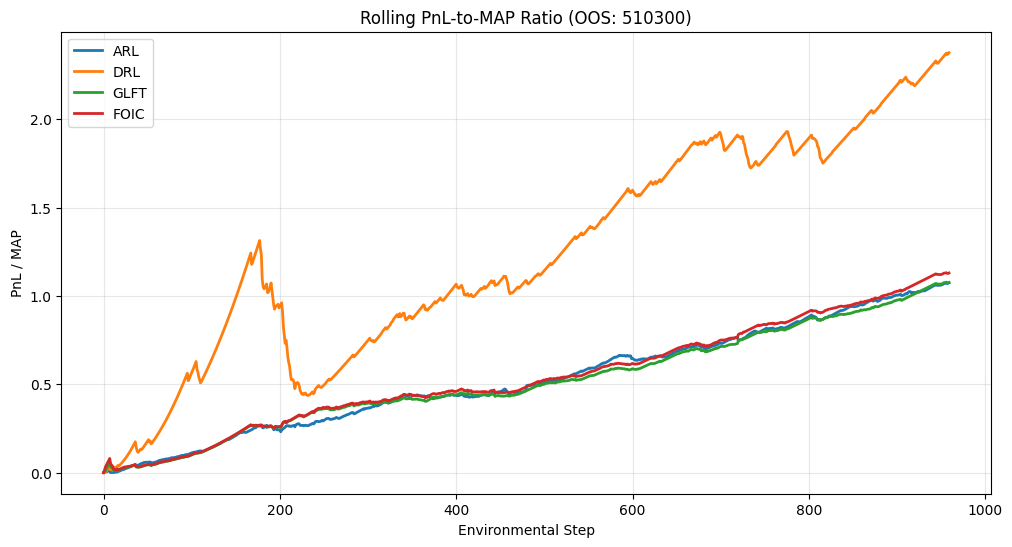

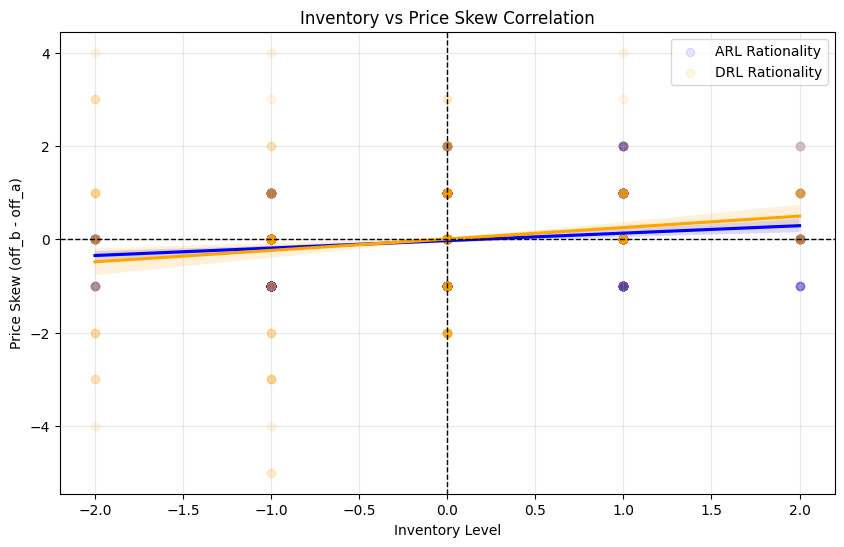

In [21]:
def get_clean_stats(df, name):
    pnl_series = df['wealth'] - df['wealth'].iloc[0]
    rolling_map = df['inventory'].abs().expanding().mean()
    pnl_map_series = pnl_series / np.maximum(rolling_map, 1e-2)
    
    returns = df['wealth'].diff().dropna()
    sharpe = returns.mean() / (returns.std() + 1e-9)
    mdd = (df['wealth'] - df['wealth'].cummax()).min()
    fills = df['fill_buy'].sum() + df['fill_sell'].sum()
    
    return {
        'Method': name.upper(),
        'PnL-to-MAP': round(pnl_map_series.iloc[-1], 4),
        'Sharpe': round(sharpe, 4),
        'Fills': int(fills)
    }

results = [get_clean_stats(dfs[m], m) for m in methods if m in dfs]
stats_df = pd.DataFrame(results)
print("\n=== Performance Summary ===")
print(stats_df.to_string(index=False))

plt.figure(figsize=(12, 6))

for m in methods:
    if m in dfs:
        df = dfs[m]
        pnl_series = df['wealth'] - df['wealth'].iloc[0]
        rolling_map = df['inventory'].abs().expanding().mean()
        safe_map = np.maximum(rolling_map, 0.1)
        pnl_map_series = pnl_series / safe_map
        plt.plot(pnl_map_series.index, pnl_map_series.values, label=f"{m.upper()}", linewidth=2.0)

plt.title(f"Rolling PnL-to-MAP Ratio (OOS: {symbol})")
plt.xlabel("Environmental Step")
plt.ylabel("PnL / MAP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
for m, color in zip(['arl', 'drl'], ['blue', 'orange']):
    if m in dfs:
        sample_df = dfs[m].sample(n=min(3000, len(dfs[m])))
        sns.regplot(data=sample_df, x='inventory', y='skew', 
                    label=f'{m.upper()} Rationality', 
                    scatter_kws={'alpha':0.1, 'color': color}, 
                    line_kws={'color': color})

plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.title("Inventory vs Price Skew Correlation")
plt.xlabel("Inventory Level")
plt.ylabel("Price Skew (off_b - off_a)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Conclusion ##

The orange line with significant positive slope proves that DRL could automatically increase skewness in orders as the inventory level increases.